### Меню <a id='start'></a>
- [Анализ распределения целевой переменной](#target)
- [Анализ распределения признаков](#features)
- [Baseline](#baseline)


In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold,cross_validate
from sklearn.metrics import classification_report, plot_confusion_matrix, precision_recall_curve, roc_curve, auc

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imb_Pipeline

In [2]:
TRAIN_PATH = 'data/train.csv'
TEST_PATH = 'data/test.csv'
RANDOM_STATE = 111

In [3]:
# df_test = pd.read_csv(TEST_PATH, index_col=0)
# print("train.shape = {} rows, {} cols".format(*df_test.shape))

In [4]:
# df_test

In [5]:
df_train = pd.read_csv(TRAIN_PATH, index_col=0)
print("train.shape = {} rows, {} cols".format(*df_train.shape))

train.shape = 831653 rows, 257 cols


In [6]:
df_train.head()

,id,vas_id,buy_time,target,0,1,2,3,4,5,...,243,244,245,246,247,248,249,250,251,252
0,540968,8.0,1537131600,0.0,-31.559971,327.360888,-45.500786,274.753202,-50.918246,253.64821,...,-845.373846,-613.770792,-20.996269,-37.630448,-28.747724,4.167111,7.305572,-12.175933,21.54386,0.0
1,1454121,4.0,1531688400,0.0,547.270029,238.430888,533.329214,274.803202,527.911754,253.69821,...,-972.373846,-613.770792,-25.996269,-19.630448,-278.747724,-24.832889,-0.694428,-11.175933,-0.45614,0.0
2,2458816,1.0,1534107600,0.0,-92.139971,-95.469112,-106.080786,-139.596798,-111.498246,-142.90179,...,-977.373846,-613.770792,-25.996269,-37.630448,-304.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
3,3535012,5.0,1535922000,0.0,54.880029,12.970888,54.079214,-9.116798,48.661754,-30.22179,...,-977.373846,-613.770792,-25.996269,-18.630448,-133.747724,-14.832889,-0.694428,-1.175933,-0.45614,0.0
4,1693214,1.0,1535922000,0.0,45.160029,295.240888,64.679214,344.283202,59.261754,323.17821,...,-965.373846,-612.770792,-22.996269,-32.630448,-127.747724,-4.832889,-0.694428,-12.175933,-0.45614,0.0


In [7]:
X = df_train.drop('target', axis=1)
y = df_train['target']

In [8]:
del df_train

In [9]:
print(f'Количество пропущенных значений: {X.isnull().sum().sum()}')

Количество пропущенных значений: 0


## Анализ распределения целевой переменной <a id='target'></a>
[В начало](#start)

In [10]:
print('Количественное соотношение:')
y.value_counts()

Количественное соотношение:


0.0    771467
1.0     60186
Name: target, dtype: int64

Процентное соотношение:


0.0    0.927631
1.0    0.072369
Name: target, dtype: float64

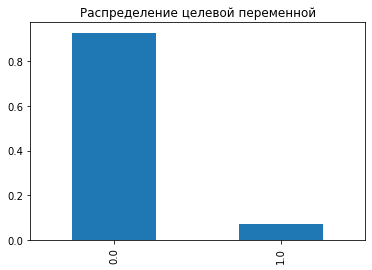

In [11]:
(y.value_counts()/y.shape[0]).plot(kind='bar', title='Распределение целевой переменной');
print('Процентное соотношение:')
y.value_counts()/y.shape

## Анализ распределения признаков <a id='features'></a>
[В начало](#start)

In [12]:
X_nunique = X.apply(lambda x: x.nunique(dropna=False))

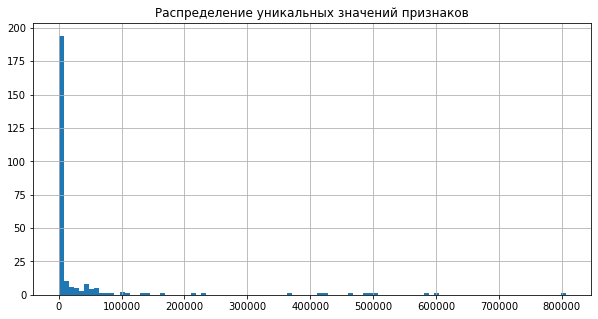

In [13]:
plt.title("Распределение уникальных значений признаков");
X_nunique.hist(bins=100, figsize=(10, 5));

In [14]:
X.head()

,id,vas_id,buy_time,0,1,2,3,4,5,6,...,243,244,245,246,247,248,249,250,251,252
0,540968,8.0,1537131600,-31.559971,327.360888,-45.500786,274.753202,-50.918246,253.64821,49.15382,...,-845.373846,-613.770792,-20.996269,-37.630448,-28.747724,4.167111,7.305572,-12.175933,21.54386,0.0
1,1454121,4.0,1531688400,547.270029,238.430888,533.329214,274.803202,527.911754,253.69821,-16.08618,...,-972.373846,-613.770792,-25.996269,-19.630448,-278.747724,-24.832889,-0.694428,-11.175933,-0.45614,0.0
2,2458816,1.0,1534107600,-92.139971,-95.469112,-106.080786,-139.596798,-111.498246,-142.90179,-16.08618,...,-977.373846,-613.770792,-25.996269,-37.630448,-304.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
3,3535012,5.0,1535922000,54.880029,12.970888,54.079214,-9.116798,48.661754,-30.22179,60.17382,...,-977.373846,-613.770792,-25.996269,-18.630448,-133.747724,-14.832889,-0.694428,-1.175933,-0.45614,0.0
4,1693214,1.0,1535922000,45.160029,295.240888,64.679214,344.283202,59.261754,323.17821,-16.08618,...,-965.373846,-612.770792,-22.996269,-32.630448,-127.747724,-4.832889,-0.694428,-12.175933,-0.45614,0.0


In [15]:
f_all = set(X_nunique.index.tolist())
print(f'Количество признаков: {len(f_all)}')

Количество признаков: 256


In [16]:
f_const = set(X_nunique[X_nunique == 1].index.tolist())
print(f'Количество константных признаков: {len(f_const)}')

Количество константных признаков: 5


In [17]:
f_numeric = (X.fillna(0).astype(int).sum() - X.fillna(0).sum()).abs()
f_numeric = set(f_numeric[f_numeric > 0].index.tolist())
print(f'Количество числовых признаков: {len(f_numeric)}')

Количество числовых признаков: 247


In [18]:
f_binary = set(X.loc[:, f_numeric].columns[(
                      (X.loc[:, f_numeric].max() == 1) & \
                      (X.loc[:, f_numeric].min() == 0) & \
                      (X.loc[:, f_numeric].isnull().sum() == 0))])
print(f'Количество Бинарных признаков: {len(f_binary)}')


Количество Бинарных признаков: 0


In [19]:
f_other = f_all - (f_numeric | f_const)
print(f'Количество остальных признаков: {len(f_other)}')

Количество остальных признаков: 4


In [20]:
X[f_other]

,buy_time,id,vas_id,252
0,1537131600,540968,8.0,0.0
1,1531688400,1454121,4.0,0.0
2,1534107600,2458816,1.0,0.0
3,1535922000,3535012,5.0,0.0
4,1535922000,1693214,1.0,0.0
...,...,...,...,...
860047,1546203600,3812226,2.0,0.0
860048,1546203600,2480469,2.0,0.0
860049,1546203600,158236,2.0,0.0
860050,1546203600,1825525,2.0,1.0


Из buy_time сгенерируем остальные фичи. id удалим. Остальные оставим без изменений. Также удалим константные колонки

In [21]:
#X['buy_time'] = pd.to_datetime(X['buy_time'],unit='s')

In [22]:
X.drop(columns=list(f_const)+['id'], axis=1, inplace=True)

In [23]:
X.head(2)

,vas_id,buy_time,0,1,2,3,4,5,6,7,...,243,244,245,246,247,248,249,250,251,252
0,8.0,1537131600,-31.559971,327.360888,-45.500786,274.753202,-50.918246,253.64821,49.15382,195.883903,...,-845.373846,-613.770792,-20.996269,-37.630448,-28.747724,4.167111,7.305572,-12.175933,21.54386,0.0
1,4.0,1531688400,547.270029,238.430888,533.329214,274.803202,527.911754,253.69821,-16.08618,-65.076097,...,-972.373846,-613.770792,-25.996269,-19.630448,-278.747724,-24.832889,-0.694428,-11.175933,-0.45614,0.0


In [24]:
f_categorical = set(X_nunique.loc[f_numeric][X_nunique.loc[f_numeric] <= 10].index.tolist())
f_categorical = list(f_categorical)
print(f'Количество категориальных признаков: {len(f_categorical)}')

Количество категориальных признаков: 29


In [25]:
X[f_categorical]=X[f_categorical].astype('category')
X = pd.get_dummies(X, drop_first=False)

## Baseline <a id='baseline'></a>
[В начало](#start)

- В качестве бейзлайна будет использоваться логистическая регрессия с l2 регуляризацией.
- PCA 50 
- В качестве solver выбран saga (т.к. solver поумолчанию выдаст ошибку)
- В sklearn pipeline нельзя использовать SMOTE, данный pipline загрузим из imblearn

In [26]:
train_idx, test_idx = train_test_split(X.index, test_size=0.25, random_state=RANDOM_STATE)

y_train, y_test = y.loc[train_idx], y.loc[test_idx]
X_train, X_test = X.loc[train_idx], X.loc[test_idx]

print("Train")
print(y.loc[train_idx].value_counts()/train_idx.shape[0])
print()
print("Test")
print(y.loc[test_idx].value_counts()/test_idx.shape[0])

Train
0.0    0.92767
1.0    0.07233
Name: target, dtype: float64

Test
0.0    0.927513
1.0    0.072487
Name: target, dtype: float64


In [27]:
del X, y

In [28]:
smote = SMOTE(sampling_strategy='auto', n_jobs=-1)

In [29]:
step_scaler = ('scaler', MinMaxScaler())
step_pca = ('pca', PCA(n_components=50))
step_smote = ('smote', smote)
step_log_reg = ('log_reg', LogisticRegression(random_state=RANDOM_STATE, penalty='l2', solver='saga'))

In [30]:
baseline_pipeline = imb_Pipeline([
    step_scaler,
    step_pca,
    step_smote,
    step_log_reg
], verbose=True)

In [36]:
kfold_cv = KFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

def run_cv(estimator, cv, X, y, scoring='f1_macro', model_name=""):
    cv_res = cross_validate(estimator, X, y, cv=cv, scoring=scoring, n_jobs=-1)
    
    print("%s: %s = %0.2f (+/- %0.2f)" % (model_name,
                                         scoring,
                                         cv_res['test_score'].mean(),
                                         cv_res['test_score'].std() * 2))

In [37]:
run_cv(baseline_pipeline, kfold_cv, X_train, y_train, model_name="Baseline");

Baseline: f1_macro = 0.57 (+/- 0.00)


In [38]:
baseline_pipeline.fit(X_train, y_train)

bl_y_pred = baseline_pipeline.predict_proba(X_test)[:,1]

[Pipeline] ............ (step 1 of 4) Processing scaler, total=   2.4s
[Pipeline] ............... (step 2 of 4) Processing pca, total=  14.5s
[Pipeline] ............. (step 3 of 4) Processing smote, total=  46.6s
[Pipeline] ........... (step 4 of 4) Processing log_reg, total=  20.3s


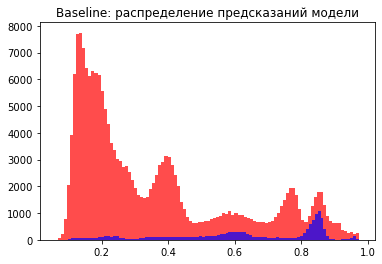

In [39]:
plt.title("Baseline: распределение предсказаний модели")
plt.hist(bl_y_pred[~y_test.astype(bool)], bins=100, color='r', alpha=0.7);
plt.hist(bl_y_pred[y_test.astype(bool)], bins=100, color='b', alpha=0.7);